In [1]:
import numpy as np
import sys
import psi4
from helper_PFCI import PFHamiltonianGenerator
np.set_printoptions(threshold=sys.maxsize)
import scipy
from scipy.optimize import curve_fit
from scipy import interpolate
from matplotlib import pyplot as plt
from scipy import constants
from numpy.polynomial import Polynomial

In [2]:
mol_str = """
H
H 1 0.74
symmetry c1
"""

# options for the PFHamiltonian Generator class - include cavity effects
cavity_dict = {
    'omega_value' : 0.12086,
    'lambda_vector' : np.array([0, 0, 0.05]),
    'ci_level' : 'fci',   
    'full_diagonalization' : True,
    'number_of_photons' : 1, #<== this is a minimal photon basis, should explore increasing this 
}

# options for PFHamiltonian Generator class - exclude cavity effects
cavity_free_dict = {
    'omega_value' : 0.0,
    'lambda_vector' : np.array([0, 0, 0.0]),
    'ci_level' : 'fci',   
    'full_diagonalization' : True,
    'number_of_photons' : 0, }

In [3]:
mol_tmpl = """
H
H 1 **R**
symmetry c1
"""
options_dict = {
    "basis": "6-311G",
    "scf_type": "pk",
    "e_convergence": 1e-10,
    "d_convergence": 1e-10,
    'num_roots' : 2
}

# number of bondlengths in the scan
N_R = 50

# number of electronic states to save
N_el = 8

# array  for energies inside the cavity
cavity_E_array = np.zeros((N_R, N_el))

n = 50

x_min = 0.5

x_max = 1.0

r_data = np.linspace(x_min, x_max, n)
psi4.set_options(options_dict)
fci_S0 = []
fci_S1 = []
r_idx = 0
for r in r_data:
    mol_str = mol_tmpl.replace("**R**", str(r))
    mol = psi4.geometry(mol_str)
    scf_e, wfn = psi4.energy('SCF', return_wfn=True)
    fci_energy, wfn = psi4.energy('fci',ref_wfn=wfn, return_wfn=True)
    fci_S0.append(wfn.variable("CI ROOT 0 TOTAL ENERGY"))
    fci_S1.append(wfn.variable("CI ROOT 1 TOTAL ENERGY"))
    cav = PFHamiltonianGenerator(mol_str, options_dict, cavity_dict)
    cavity_E_array[r_idx,:] = cav.CIeigs[:N_el]
    r_idx += 1


Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEM92KWMALT
*** at Tue Jan 16 16:33:53 2024

   => Loading Basis Set <=

    Name: 6-311G
    Role: ORBITAL
    Keyword: BASIS
    atoms 1-2 entry H          line    21 file /Users/ptolley1/anaconda3/envs/work/share/psi4/basis/6-311g.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c1
    Full point group: D_inf_h

    Geometry (in Angstrom), charg

Min on S0 is 0.7448979591836735
        5         4        3         2
-3.804 x + 16.89 x - 30.6 x + 28.51 x - 13.59 x + 1.476
538.2264333927617


<function matplotlib.pyplot.show(close=None, block=None)>

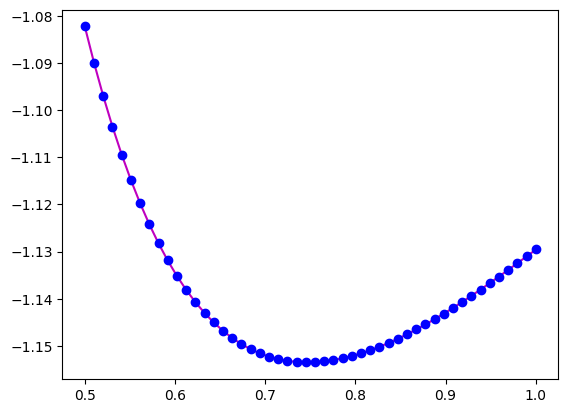

In [4]:
au_to_SI = (4.35974 * 10 ** (-18)) * 10 ** 20
min_S0_loc = np.argmin(fci_S0[:])
r_eq_ang = r_data[min_S0_loc]
print(f'Min on S0 is {r_data[min_S0_loc]}')

# Fitting S0 PES to a quintic polynomial
poly = np.poly1d(np.polyfit(r_data, fci_S0, 5))
print(poly)

#Taking first and second derivative of S0 PES and evaluating at r_eq
first_derivative = poly.deriv()
second_derivative = first_derivative.deriv()
k_test_au = second_derivative(r_eq_ang)
k_test_SI = k_test_au * au_to_SI
print(k_test_SI)

#plotting S0 PES and quintic fit
plt.plot(r_data, poly(r_data), 'm-', label='fit')
plt.plot(r_data, fci_S0[:], 'bo', label='cavity free |g>')
plt.show

In [9]:
r_eq_SI = r_eq_ang * 10 ** (-10)
r_data_SI = r_data * 10 ** (-10)
delta_x = (10 ** (-10)) * x_max - x_min / n 
l = (n - 1) * delta_x
mu = (1.007 * 1.007 / (1.007 + 1.007)) / (1000 * 6.022 * 10 ** 23)
hbar = scipy.constants.hbar
D_e_kJ_mol = 435.780 
D_e_J = D_e_kJ_mol * 1000 / (6.022* 10 ** 23)
a = np.sqrt(k_test_SI / (2 * D_e_J))
T_l = hbar ** 2 / (2 * mu)
T_ij = np.zeros((n, n))
V_ij = np.zeros((n, n))
H_ij = np.zeros((n, n))
for i in range(n):
    for j in range(n):
        T_ij[i,j] = np.cos(2 * np.pi * l * (i - j / (n - 1))) * T_l
        V_ij[i,j] = D_e_J * (1 - np.exp(-a * (r_data_SI[i] - r_eq_SI))) ** 2 * i==j
        H_ij = T_ij + V_ij
print(H_ij)

H_diag = np.linalg.eigh(H_ij)
eigenvalues = H_diag.eigenvalues
eigenvectors = H_diag.eigenvectors
print(f'the eigenvales are {eigenvalues}')
print(f'the eigenvectors are {eigenvectors}')

[[ 1.00000000e+00  6.63751897e-42  6.59820019e-42  6.53284133e-42
   6.44170033e-42  6.32513689e-42  6.18361101e-42  6.01768126e-42
   5.82800246e-42  5.61532320e-42  5.38048282e-42  5.12440814e-42
   4.84810976e-42  4.55267811e-42  4.23927912e-42  3.90914963e-42
   3.56359251e-42  3.20397152e-42  2.83170592e-42  2.44826487e-42
   2.05516163e-42  1.65394762e-42  1.24620622e-42  8.33546624e-43
   4.17597397e-43  1.04468048e-49 -4.17597189e-43 -8.33546417e-43
  -1.24620602e-42 -1.65394741e-42 -2.05516143e-42 -2.44826467e-42
  -2.83170573e-42 -3.20397133e-42 -3.56359233e-42 -3.90914946e-42
  -4.23927896e-42 -4.55267796e-42 -4.84810962e-42 -5.12440801e-42
  -5.38048270e-42 -5.61532309e-42 -5.82800236e-42 -6.01768117e-42
  -6.18361094e-42 -6.32513682e-42 -6.44170028e-42 -6.53284129e-42
  -6.59820016e-42 -6.63751896e-42]
 [-6.63751896e-42 -6.59820016e-42 -6.53284129e-42 -6.44170028e-42
  -6.32513682e-42 -6.18361094e-42 -6.01768117e-42 -5.82800236e-42
  -5.61532309e-42 -5.38048270e-42 -5.1244